In [2]:
from fastai2.basics import *
from fastai2.tabular.all import *
from fast_tabnet.core import *

import pandas as pd

In [4]:
df = pd.read_csv('data/adult_csv.csv')

In [5]:
df_main, df_test = df.iloc[:-1000].copy(),df.iloc[-1000:].copy()
df_main.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


In [9]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race' ,'sex', 'native-country']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df_main))

In [10]:
to = TabularPandas(df_main, procs, cat_names, cont_names, y_names="class", y_block = CategoryBlock(), splits=splits)

In [11]:
dls = to.dataloaders()

In [12]:
dls.valid.show_batch()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,fnlwgt,education-num,class
0,#na#,HS-grad,Widowed,#na#,Unmarried,White,Female,United-States,3.000000e+00,224107.998599,9.0,<=50K
1,Private,Bachelors,Divorced,Exec-managerial,Not-in-family,White,Female,United-States,2.000000e+00,112811.999562,13.0,<=50K
2,Private,5th-6th,Never-married,Other-service,Other-relative,White,Female,El-Salvador,1.000000e+00,255816.999427,3.0,<=50K
3,State-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,3.000000e+00,118446.998925,13.0,>50K
4,Local-gov,Assoc-voc,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,2.000000e+00,282069.000801,11.0,<=50K
5,Private,Some-college,Never-married,Craft-repair,Unmarried,White,Male,Mexico,1.000000e+00,201578.999651,10.0,<=50K
6,Self-emp-not-inc,1st-4th,Divorced,Craft-repair,Not-in-family,White,Female,United-States,4.000000e+00,130436.001785,2.0,<=50K
7,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,1.000000e+00,274963.996944,9.0,<=50K
8,Private,HS-grad,Never-married,Protective-serv,Not-in-family,White,Male,United-States,1.000000e+00,277454.999537,9.0,<=50K
9,Private,HS-grad,Never-married,Other-service,Own-child,Black,Male,United-States,-1.646453e-08,164441.000010,9.0,<=50K


In [13]:
to_tst = to.new(df_test)
to_tst.process()
to_tst.all_cols.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,fnlwgt,education-num,class
47842,4,16,5,6,4,5,2,39,0.179925,0.128524,-0.032458,0
47843,4,12,3,10,1,5,2,39,-0.593398,-0.263876,-0.421646,0
47844,6,12,3,12,1,5,2,39,-0.593398,1.082597,-0.421646,1
47845,4,12,1,14,2,5,2,39,0.179925,-0.429624,-0.421646,0
47846,0,12,5,0,2,5,2,39,-0.593398,-1.387214,-0.421646,0


In [14]:
emb_szs = get_emb_sz(to); print(emb_szs)

[(9, 5), (17, 8), (8, 5), (15, 7), (7, 5), (6, 4), (3, 3), (42, 13)]


In [15]:
model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=8, n_a=32, n_steps=1); 

In [17]:
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.033113110810518265)

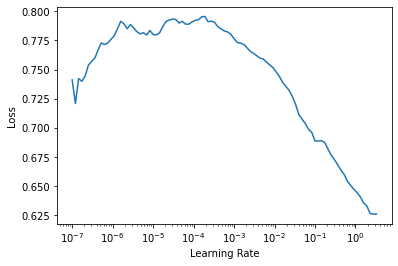

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.400832,0.399150,0.821279,00:27
1,0.386772,0.417034,0.821802,00:27
2,0.368706,0.370851,0.832253,00:27
3,0.355739,0.361925,0.832044,00:27
4,0.347055,0.356403,0.835702,00:27
5,0.349613,0.354350,0.834239,00:27
6,0.358967,0.348901,0.838733,00:27
7,0.352339,0.348220,0.839151,00:27
8,0.341916,0.347342,0.839047,00:27
9,0.358373,0.348026,0.839674,00:27


In [21]:
from functools import lru_cache

In [22]:
# The function we'll optimize
@lru_cache(1000)
def get_accuracy(n_d:Int, n_a:Int, n_steps:Int):
    model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=1.5)
    learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])
    learn.fit_one_cycle(5)
    return float(learn.validate(dl=learn.dls.valid)[1])

This implementaion of Bayesian Optimization doesn't work naturally with descreet values. That's why we use wrapper with _lru_cahe_

In [23]:
def fit_accuracy(pow_n_d, pow_n_a, pow_n_steps):
    n_d, n_a, n_steps = map(lambda x: 2**int(x), (pow_n_d, pow_n_a, pow_n_steps))
    return get_accuracy(n_d, n_a, n_steps)

In [24]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'pow_n_d': (0, 8), 'pow_n_a': (0, 8), 'pow_n_steps': (0, 4)}

optimizer = BayesianOptimization(
    f=fit_accuracy,
    pbounds=pbounds,
)

In [ ]:
optimizer.maximize(
    init_points=15,
    n_iter=100,
)

In [26]:
optimizer.max['target']

0.8381062150001526

In [27]:
{key: 2**int(value)
  for key, value in optimizer.max['params'].items()}

{'pow_n_a': 32, 'pow_n_d': 8, 'pow_n_steps': 1}